In [1]:
from google.colab import files
import os

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.applications import Xception
from keras.layers import Input
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import itertools

%matplotlib inline

#Setting up the environment

In [2]:
!pip install kaggle==1.5.9
!kaggle -v
os.environ['KAGGLE_USERNAME'] = "YOUR_USERNAME" # username from the json file
os.environ['KAGGLE_KEY'] = "YOUR_KEY" # key from the json file
!kaggle competitions download -c mais-202-fall-2020-kaggle-competition

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
 98% 193M/196M [00:02<00:00, 79.6MB/s]
100% 196M/196M [00:02<00:00, 71.6MB/s]
  0% 0.00/341k [00:00<?, ?B/s]
100% 341k/341k [00:00<00:00, 107MB/s]
100% 783M/784M [00:09<00:00, 87.3MB/s]
100% 784M/784M [00:09<00:00, 82.3MB/s]


In [3]:
!unzip /content/test_x.npy.zip
!unzip /content/train_x.npy.zip

Archive:  /content/test_x.npy.zip
  inflating: test_x.npy              
Archive:  /content/train_x.npy.zip
  inflating: train_x.npy             


In [4]:
train_images = np.load("train_x.npy")
test_x = np.load("test_x.npy")
train_y = np.genfromtxt("train_y.csv", dtype=int, delimiter=',', skip_header=1, usecols=1)

#Data preprocessing

In [5]:
def clean(img):
  _, thresh = cv2.threshold(img.astype(np.uint8), 235, 255, cv2.THRESH_BINARY)
  thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB) #pseudo RGB image
  return thresh

In [6]:
#clean up training set images
x_train = []
for img in train_images:
  x_train.append(clean(img))

x_train = np.array(x_train)
x_train = x_train.reshape((40000, 128, 128, 3))

#Vectorize our categories for the neural net
y_train = to_categorical(train_y)
print(x_train.shape, y_train.shape)

(40000, 128, 128, 3) (40000, 10)


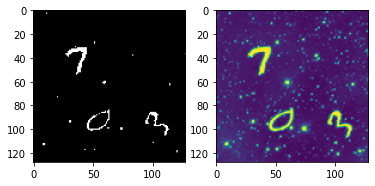

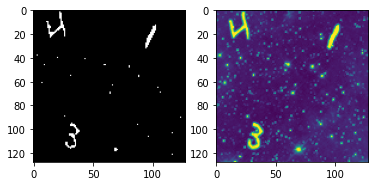

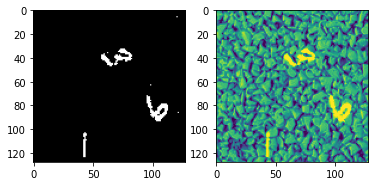

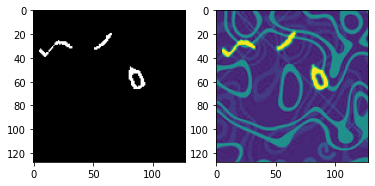

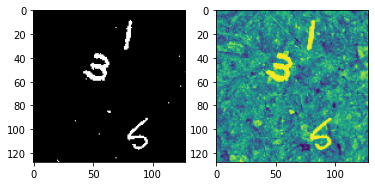

In [7]:
#Visualize a few filtered and raw images
for i in range(10, 15):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  im = ax1.imshow(x_train[i])
  im2 = ax2.imshow(train_images[i])

  plt.show()

In [8]:
#Define a function to create directories for our ImageDataGenerator
def im_to_dir(num, image, category, dir):
  img = Image.fromarray(image)
  name = "image" + str(num) + ".jpg"
  path = "{}/{}/{}".format(dir, category, name)
  img.save(path)

In [9]:
os.mkdir('x_train')

for i in range(10):
  os.mkdir("x_train/{}".format(i))

#Training set of 36000/40000 images
for i in range(36000):
  im_to_dir(i, x_train[i], train_y[i], 'x_train')

In [10]:
os.mkdir('x_valid')

for i in range(10):
  os.mkdir("x_valid/{}".format(i))

#Validation set of 4000/40000 images
for i in range(36000, len(x_train)):
  im_to_dir(i, x_train[i], train_y[i], 'x_valid')

In [11]:
#Do data augmentation and rescaling
from keras_preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,   
    rotation_range=25,  #changed to 25
    width_shift_range=0.2,
    height_shift_range=0.2) 

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05)

#Building our model

In [13]:
#Define a learning rate scheduler function
def scheduler(epoch, lr):
  if epoch < 10:    #Changed to 10
    return lr
  else:
    return lr * tf.math.exp(-0.1)

reduce_lr = LearningRateScheduler(schedule=scheduler, verbose=1)

In [14]:
#Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

In [20]:
# Count the number of occurences in each class in the training set
from collections import Counter
instances_per_class = dict(Counter(train_y[:37000]))

# Make a dict of class weights to use in the model later
class_weights = []
for category in instances_per_class.keys():
  weight = 37000/(10*instances_per_class[category]) # weight of a class = n_samples/(n_classes*samples_in_class)
  class_weights.append((category, weight))

class_weights = dict(class_weights)

In [20]:
#Create our model using an Xception architecture with no initial weights
new_input = Input(shape=(128, 128, 3))
model = Xception(weights=None, input_tensor=new_input, classes=10)

In [21]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
#First training round using in-place image data generation
history = model.fit(x=train_datagen.flow_from_directory(
    directory=r"x_train",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True
),
    validation_data=valid_datagen.flow_from_directory(
    directory=r"x_valid",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True
),
    epochs=40,
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weights
)

Found 36000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/40
1125/1125 [==============================] - 254s 225ms/step - loss: 2.5066 - accuracy: 0.0868 - val_loss: 2.4542 - val_accuracy: 0.0140

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/40
1125/1125 [==============================] - 254s 226ms/step - loss: 2.3592 - accuracy: 0.1007 - val_loss: 2.1976 - val_accuracy: 0.2395

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/40
1125/1125 [==============================] - 254s 226ms/step - loss: 2.1871 - accuracy: 0.1304 - val_loss: 2.0949 - val_accuracy: 0.1928

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/40
1125/1125 [==============================] - 249s 222ms/step - loss: 2.1790 - accuracy: 0.1333 - val_loss: 2.0781 - va

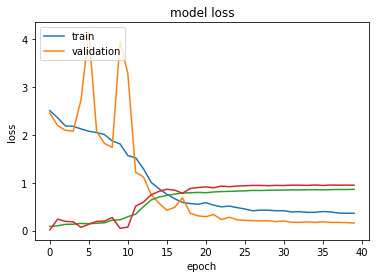

In [25]:
# summarize history for loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
!unzip /content/modelX_train1.zip

Archive:  /content/modelX_train1.zip
   creating: modelX_train1/
   creating: modelX_train1/variables/
  inflating: modelX_train1/variables/variables.index  
  inflating: modelX_train1/variables/variables.data-00000-of-00001  
   creating: modelX_train1/assets/
  inflating: modelX_train1/saved_model.pb  


In [14]:
model = tf.keras.models.load_model('modelX_train1')

In [15]:
#Define a learning rate scheduler function for second training phase
def scheduler2(epoch, lr):
  if epoch < 2:    
    return lr
  else:
    return lr * tf.math.exp(-0.1)

reduce_lr2 = LearningRateScheduler(schedule=scheduler2, verbose=1)

In [16]:
early_stopping2 = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, restore_best_weights=True)

In [17]:
#Compile our model using SGD as an optimizer and a slow learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
#at this point, reduce epoxhs
history2 = model.fit(x_train, y_train, epochs=8, validation_split=0.10, callbacks=[reduce_lr2, early_stopping2], class_weight=class_weights)


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 1/8
1125/1125 [==============================] - 224s 199ms/step - loss: 0.1083 - accuracy: 0.9600 - val_loss: 0.1607 - val_accuracy: 0.9553

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/8
1125/1125 [==============================] - 224s 199ms/step - loss: 0.1025 - accuracy: 0.9601 - val_loss: 0.1585 - val_accuracy: 0.9542

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(9.0483736e-05, shape=(), dtype=float32).
Epoch 3/8
1125/1125 [==============================] - 224s 199ms/step - loss: 0.1001 - accuracy: 0.9599 - val_loss: 0.1565 - val_accuracy: 0.9548

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(8.187306e-05, shape=(), dtype=float32).
Epoch 4/8
1125/1125 [==============================] - 224s 199ms/step - loss: 0.0958 - accuracy: 0.9606 - val_loss: 0.1551 - val_accuracy: 0.9545

Epoch 00005: Lea

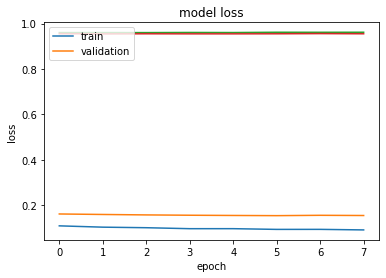

In [23]:
# summarize history for loss and accuracy
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
#Plot confusion matrix
valid_generator = valid_datagen.flow_from_directory(
    directory=r"x_valid",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)
probabilities = model.predict(valid_generator)
y_valid_pred = np.argmax(probabilities, axis=1)

Found 4000 images belonging to 10 classes.


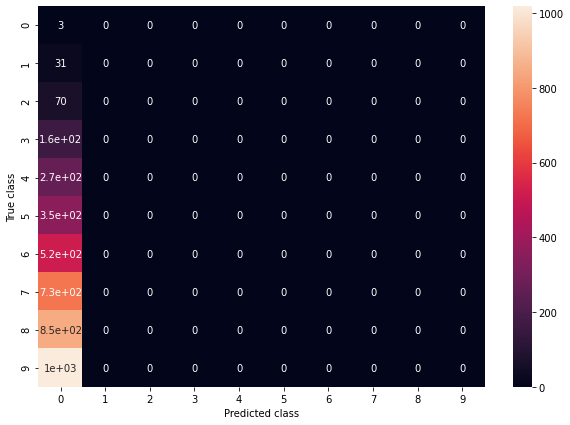

In [25]:
class_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
confusion = confusion_matrix(valid_generator.classes, y_valid_pred)

from seaborn import heatmap
f, ax = plt.subplots(figsize=(10, 7))
heatmap(confusion, ax=ax, annot=True)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
plt.show()

In [ ]:
os.mkdir('Model')
model.save('Model/model.h5')
files.download('Model/model.h5')

#Generating predictions

In [30]:
#Preprocessing the test data
x_test = []
for img in test_x:
  x_test.append(clean(img))
x_test = np.array(x_test)
x_test = np.reshape(x_test, (10000, 128, 128, 3))

In [31]:
#Generate predictions
probs = modelX_train1.predict(x_test)
preds = np.argmax(probs, axis=1)

In [32]:
#Save predictions to a dataframe
df = pd.DataFrame(preds, columns=["Label"])
id = []
for i in range(len(probs)):
  id.append(i)
df["Id"] = id
df.set_index("Id", inplace=True)
df.tail(10)

,Label
Id,
9990,9
9991,7
9992,7
9993,3
9994,8
9995,5
9996,9
9997,5
9998,3


In [33]:
#Save predictions to csv file
df.to_csv("predictions_kaggle_competition")